# Tree segmentation with multitemporal Sentinel 1/2 imagery

## John Brandt
## December 2023

## This notebook finetunes the TTC decoder for a new task

## Package Loading

In [1]:
import sys
!{sys.executable} -m pip install tqdm

In [2]:
from tqdm import tqdm_notebook, tnrange
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
sess = tf.Session()
#from keras import backend as K
#K.set_session(sess)

from time import sleep

import keras
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.layers import ELU
from keras.losses import binary_crossentropy
#from tensorflow.compat.v1.ops import array_ops

from tensorflow.compat.v1.layers import *
from tensorflow.compat.v1.initializers import glorot_normal, lecun_normal
from scipy.ndimage import median_filter
from skimage.transform import resize

import pandas as pd
import numpy as np
from random import shuffle
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import itertools
#from tensorflow.contrib.framework import arg_scope
#from keras.regularizers import l1
#from tensorflow.layers import batch_normalization
from tensorflow.python.util import deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Instructions for updating:
non-resource variables are not supported in the long term
Metal device set to: Apple M3 Max


2024-03-07 08:21:02.418389: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-07 08:21:02.418869: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Utility scripts

In [3]:
%run ../src/layers/zoneout.py
%run ../src/layers/losses.py
%run ../src/layers/adabound.py
%run ../src/layers/adabelief.py

%run ../src/layers/convgru.py
%run ../src/layers/dropblock.py
%run ../src/layers/extra_layers.py
%run ../src/layers/stochastic_weight_averaging.py
%run ../src/preprocessing/indices.py
%run ../src/preprocessing/slope.py

# Hyperparameter definitions

In [4]:
ZONE_OUT_PROB = 0.90
ACTIVATION_FUNCTION = 'swish'

INITIAL_LR = 1e-3
DROPBLOCK_MAXSIZE = 5

N_CONV_BLOCKS = 1
FINAL_ALPHA = 0.33
LABEL_SMOOTHING = 0.03

L2_REG = 0.
BATCH_SIZE = 32
MAX_DROPBLOCK = 0.6

FRESH_START = True
best_val = 0.2

START_EPOCH = 1
END_EPOCH = 100

n_bands = 17
initial_flt = 32
mid_flt = 32 * 2
high_flt = 32 * 2 * 2

temporal_model = True
bi = True
input_size = 172
output_size = 14

# Custom layer definitions

### Conv GRU Block

In [5]:
def gru_block(inp, length, size, flt, scope, train, normalize = True, bi = False):
    '''Bidirectional convolutional GRU block with 
       zoneout and CSSE blocks in each time step

         Parameters:
          inp (tf.Variable): (B, T, H, W, C) layer
          length (tf.Variable): (B, T) layer denoting number of
                                steps per sample
          size (int): kernel size of convolution
          flt (int): number of convolution filters
          scope (str): tensorflow variable scope
          train (tf.Bool): flag to differentiate between train/test ops
          normalize (bool): whether to compute layer normalization

         Returns:
          gru (tf.Variable): (B, H, W, flt*2) bi-gru output
          steps (tf.Variable): (B, T, H, W, flt*2) output of each step
    '''
    with tf.variable_scope(scope):
        print(f"GRU input shape {inp.shape}, zoneout: {ZONE_OUT_PROB}")
        
        # normalize is internal group normalization within the reset gate
        # sse is internal SSE block within the state cell

        cell_fw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID', 
                           normalize = normalize, sse = True)
        cell_fw = ZoneoutWrapper(
           cell_fw, zoneout_drop_prob = 0.75, is_training = train)
        if bi:
            cell_bw = ConvGRUCell(shape = size, filters = flt,
                               kernel = [3, 3], padding = 'VALID',
                               normalize = normalize, sse = True)
            cell_bw = ZoneoutWrapper(
            cell_bw, zoneout_drop_prob = 0.75, is_training = train)
                
            steps, out = convGRU(inp, cell_fw, cell_bw, length)
        else:
            steps, out = fconvGRU(inp, cell_fw, length)
        gru = tf.concat(out, axis = -1)
        steps = tf.concat(steps, axis = -1)
        print(f"GRU block output shape {gru.shape}")
    return gru, steps

# Model definition

## Placeholders

In [6]:
#reg = tf.contrib.layers.l2_regularizer(0.)
n_bands = 17
output_size = input_size - 14

if temporal_model:
    inp = tf.placeholder(tf.float32, shape=(None, 5, input_size, input_size, n_bands))
    length = tf.placeholder_with_default(np.full((1,), 4), shape = (None,))
else:
    inp = tf.placeholder(tf.float32, shape=(None, input_size, input_size, n_bands  * 5))
    length = tf.placeholder_with_default(np.full((1,), 4), shape = (None,))
    
labels = tf.placeholder(tf.float32, shape=(None, output_size, output_size))#, 1))
mask = tf.placeholder(tf.float32, shape = (None, output_size, output_size))
keep_rate = tf.placeholder_with_default(1.0, ()) # For DropBlock
is_training = tf.placeholder_with_default(False, (), 'is_training') # For DropBlock
alpha = tf.placeholder(tf.float32, shape = ()) # For loss scheduling
ft_lr = tf.placeholder_with_default(0.001, shape = ()) # For loss scheduling
loss_weight = tf.placeholder_with_default(1.0, shape = ())
beta_ = tf.placeholder_with_default(0.0, shape = ()) # For loss scheduling, not currently implemented

## Layers

In [7]:
# master modmel is 32, 64, 96, 230k paramms
initial_flt = 64
mid_flt = initial_flt * 2
high_flt = initial_flt * 2 * 2

if bi:
    divider = 2
else:
    divider = 1

if temporal_model:
    gru_input = inp[:, :-1, ...]
    gru, steps = gru_block(inp = gru_input, length = length,
                                size = [input_size, input_size, ], # + 2 here for refleclt pad
                                flt = initial_flt // divider,
                                scope = 'down_16',
                                train = is_training, bi = bi)
    with tf.variable_scope("gru_drop"):
        drop_block = DropBlock2D(keep_prob=keep_rate, block_size=4)
        gru = drop_block(gru, is_training)
        
    # Median conv
    median_input = inp[:, -1, ...]
else:
    median_input = inp
    
median_conv = conv_swish_gn(inp = median_input, is_training = False, stride = (1, 1),
            kernel_size = 3, scope = 'conv_median', filters = initial_flt, 
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
            csse = True, dropblock = True, weight_decay = None,
                            window_size = 104)
#print(f"Median conv: {median_conv.shape}")

if temporal_model:
    concat1 = tf.concat([gru, median_conv], axis = -1)

else:
    concat1 = median_conv

concat = conv_swish_gn(inp = concat1, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv_concat', filters = initial_flt,
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
            csse = True, dropblock = True, weight_decay = None, padding = "SAME",
                       window_size = 104)
print(f"Concat: {concat.shape}")

# MaxPool-conv-swish-GroupNorm-csse
pool1 = MaxPool2D()(concat)
conv1 = conv_swish_gn(inp = pool1, is_training = False, stride = (1, 1),
            kernel_size = 3, scope = 'conv1', filters = mid_flt,
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True, padding = "VALID",
            csse = True, dropblock = True, weight_decay = None)
print(f"Conv1: {conv1.shape}")

# MaxPool-conv-swish-csse-DropBlock
pool2 = MaxPool2D()(conv1)
conv2 = conv_swish_gn(inp = pool2, is_training = False, stride = (1, 1),
            kernel_size = 3, scope = 'conv2', filters = high_flt, 
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
            csse = True, dropblock = True, weight_decay = None, block_size = 4, padding = "VALID",
                     window_size = 24)
print("Encoded", conv2.shape)

# Decoder 4 - 8, upsample-conv-swish-csse-concat-conv-swish
up2 = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'nearest')(conv2)
#up2 = ReflectionPadding2D((1, 1,))(up2)
up2 = conv_swish_gn(inp = up2, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up2', filters = mid_flt, 
                    keep_rate = keep_rate, activation = True,use_bias = False, norm = True,
                    csse = True, dropblock = True, weight_decay = None)
conv1_crop = Cropping2D(2)(conv1)
print(conv1_crop.shape)
up2 = tf.concat([up2, conv1_crop], -1)
#up2 = ReflectionPadding2D((1, 1,))(up2)
up2 = conv_swish_gn(inp = up2, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up2_out', filters = mid_flt, 
                    keep_rate =  keep_rate, activation = True,use_bias = False, norm = True,
                    csse = True, dropblock = True, weight_decay = None)

# Decoder 8 - 14 upsample-conv-swish-csse-concat-conv-swish
up3 = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'nearest')(up2)
#up3 = ReflectionPadding2D((1, 1,))(up3)
up3 = conv_swish_gn(inp = up3, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up3', filters = initial_flt, 
                    keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
                    csse = True, dropblock = True, weight_decay = None, 
                    window_size = 104)
gru_crop = Cropping2D(6)(concat)
print(up3.shape)
print(gru_crop.shape)
up3 = tf.concat([up3, gru_crop], -1)

up3out = conv_swish_gn(inp = up3, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'out', filters = initial_flt, 
                    keep_rate  = keep_rate, activation = True,use_bias = False, norm = True,
                    csse = True, dropblock = False, weight_decay = None, padding = "VALID",
                       window_size = 104)

init = tf.constant_initializer([-np.log(0.7/0.3)]) # For focal loss
print(f"The output is {up2.shape}, with a receptive field of {1}")
fm = tf.layers.Conv2D(filters = 1,
            kernel_size = (1, 1),
            padding = 'valid',
            activation = 'sigmoid',
            bias_initializer = init,)(up3out)#, # name = 'conv2d'
print(fm)

GRU input shape (?, 4, 172, 172, 17), zoneout: 0.9
(3, 3, 49, 64)
(3, 3, 49, 64)
GRU block output shape (?, 172, 172, 64)
conv_median 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
The non normalized feats are Tensor("conv_median_conv/conv_median/x/mul:0", shape=(?, 172, 172, 64), dtype=float32)
The non normalized feats are Tensor("IdentityN:0", shape=(?, 172, 172, 64), dtype=float32)



/Users/work/Documents/GitHub/sentinel-tree-cover/src/layers/extra_layers.py:405: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  update_mask = tf.layers.conv2d(mask, filters=1,


conv_concat 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
The non normalized feats are Tensor("conv_concat_conv/conv_concat/x/mul:0", shape=(?, 172, 172, 64), dtype=float32)
The non normalized feats are Tensor("IdentityN_1:0", shape=(?, 172, 172, 64), dtype=float32)
Concat: (?, 172, 172, 64)
conv1 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
The non normalized feats are Tensor("conv1_conv/conv1/ws_conv2d_2/WSConv2D:0", shape=(?, 84, 84, 128), dtype=float32)
The non normalized feats are Tensor("IdentityN_2:0", shape=(?, 84, 84, 128), dtype=float32)
Conv1: (?, 84, 84, 128)
conv2 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
The non normalized feats are Tensor("conv2_conv/conv2/ws_conv2d_3/WSConv2D:0", shape=(?, 40, 40, 256), dtype=float32)
The non normalized feats are Tensor("IdentityN_3:0", shape=(?, 40, 40, 256), dtype=float32)
Encoded (?, 40, 40, 256)
up2 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
The non normalized feats are Tensor("up2_conv/up2/x/mul:0", shape=(?, 80, 80

In [8]:
# It is best to finetune the decoder, freeze the convolutional layers in the encoder,
# and finetune the attention layers and the normalization in the encoder
# Decoder
finetune_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"conv2d_5") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"conv2d") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "csse_out") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "out") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "up3") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "up3_drop") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "csse_up3") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "up2_out") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "up2_out_drop") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "csse_up2_out") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "up2") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "up2_drop") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "csse_up2")# + \

# Encoder, 4x downsample norm + csse
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"conv2_norm")
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"csse_conv2")

# Encoder, 2x downsample norm + csse
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"conv1_norm")
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"csse_conv1")
#finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"conv_concat")

# Concat conv high res norm + csse
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"conv_concat_norm")
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"csse_conv_concat_conv")

# Median conv high res norm + csse
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"conv_median_norm")
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"csse_conv_median_conv")

# Conv GRU, norm only
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"down_16/bidirectional_rnn/bw/bw/while/bw/conv_gru_cell/candidate/candidate_y_norm/")
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"down_16/bidirectional_rnn/bw/bw/while/bw/conv_gru_cell/gates/gates_u_norm/")
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"down_16/bidirectional_rnn/bw/bw/while/bw/conv_gru_cell/gates/gates_r_norm")
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"down_16/bidirectional_rnn/fw/fw/while/fw/conv_gru_cell/candidate/candidate_y_norm/")
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"down_16/bidirectional_rnn/fw/fw/while/fw/conv_gru_cell/gates/gates_u_norm/")
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"down_16/bidirectional_rnn/fw/fw/while/fw/conv_gru_cell/gates/gates_r_norm")

In [9]:
# The frozen variables are the convolutional layers in the encoder
[x for x in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "") if x not in finetune_vars]

[<tf.Variable 'down_16/bidirectional_rnn/fw/conv_gru_cell/gates/kernel:0' shape=(3, 3, 49, 64) dtype=float32_ref>,
 <tf.Variable 'down_16/bidirectional_rnn/fw/conv_gru_cell/candidate/kernel:0' shape=(3, 3, 49, 32) dtype=float32_ref>,
 <tf.Variable 'down_16/bidirectional_rnn/fw/conv_gru_cell/candidate/kernel_1:0' shape=(1, 1, 32, 1) dtype=float32_ref>,
 <tf.Variable 'down_16/bidirectional_rnn/bw/conv_gru_cell/gates/kernel:0' shape=(3, 3, 49, 64) dtype=float32_ref>,
 <tf.Variable 'down_16/bidirectional_rnn/bw/conv_gru_cell/candidate/kernel:0' shape=(3, 3, 49, 32) dtype=float32_ref>,
 <tf.Variable 'down_16/bidirectional_rnn/bw/conv_gru_cell/candidate/kernel_1:0' shape=(1, 1, 32, 1) dtype=float32_ref>,
 <tf.Variable 'conv_median_conv/conv_median/x/ws_conv2d/kernel:0' shape=(3, 3, 17, 64) dtype=float32>,
 <tf.Variable 'conv_concat_conv/conv_concat/x/ws_conv2d_1/kernel:0' shape=(3, 3, 128, 64) dtype=float32>,
 <tf.Variable 'conv1_conv/conv1/ws_conv2d_2/kernel:0' shape=(3, 3, 64, 128) dtype=f

In [10]:
def grad_norm(gradients):
    norm = tf.compat.v1.norm(
        tf.stack([
            tf.compat.v1.norm(grad) for grad in gradients if grad is not None
        ])
    )
    return norm

FRESH_START = True
#print(f"Starting model with: \n {ZONE_OUT_PROB} zone out \n {L2_REG} l2 \n"
 #     f"{INITIAL_LR} initial LR \n {total_parameters} parameters")  

OUT = input_size - 14
if FRESH_START:
    # We use the Adabound optimizer
    optimizer = AdaBoundOptimizer(1e-4, 1e-2)#2e-4, 2e-2)
    #optimizer = AdaBeliefOptimizer(1e-3)#2e-4, 2e-2)
    #train_loss1 = logcosh(tf.reshape(labels, (-1, 14, 14, 1)), output) 
    
    train_loss2 = bce_surface_loss(tf.reshape(labels, (-1, OUT, OUT, 1)), fm,
                                  weight = loss_weight, 
                             alpha = alpha, beta = beta_, mask = mask)

    train_loss = train_loss2# + train_loss2
    
    # If there is any L2 regularization, add it. Current model does not use
    l2_loss = tf.losses.get_regularization_loss()
    if len(tf.losses.get_regularization_losses()) > 0:
        train_loss = train_loss + l2_loss
        
    test_loss = bce_surface_loss(tf.reshape(labels, (-1, OUT, OUT, 1)),
                            fm, weight = loss_weight, 
                            alpha = alpha, beta = beta_, mask = mask)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(train_loss)#, var_list = finetune_vars)   
        #ft_op = ft_optimizer.minimize(train_loss)
    
    # The following code blocks are for sharpness aware minimization
    # Adapted from https://github.com/sayakpaul/Sharpness-Aware-Minimization-TensorFlow
    # For tensorflow 1.15
    trainable_params = tf.trainable_variables()
    gradients = optimizer.compute_gradients(loss=train_loss, var_list=None)
    gradient_norm = grad_norm(gradients)
    scale = 0.05 / (gradient_norm + 1e-12)
    e_ws = []
    for (grad, param) in gradients:
        e_w = grad * scale
        param.assign_add(e_w)
        e_ws.append(e_w)

    sam_gradients = optimizer.compute_gradients(loss=train_loss, var_list=None)
    for (param, e_w) in zip(trainable_params, e_ws):
        param.assign_sub(e_w)
    train_step = optimizer.apply_gradients(sam_gradients)
    
    # Create a saver to save the model each epoch
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    saver = tf.train.Saver(max_to_keep = 150)#, var_list = all_vars)

2024-03-07 08:21:07.923723: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2024-03-07 08:21:08.107254: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-03-07 08:21:08.118650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [11]:
def make_saver_varlist(path):

    current_items = []
    vars_dict = {}
    for var_current in tf.global_variables():
        current_items.append(var_current) 
    names = [x.op.name for x in current_items]
    names = np.argsort(names)
    current_items = [current_items[x] for x in names]
    
    ckpt_items = []
    for var_ckpt in tf.train.list_variables(path):
        if 'save' in var_ckpt[0]:
            print(var_ckpt[0])
        if 'BackupVariables' not in var_ckpt[0]:
            if 'StochasticWeightAveraging' not in var_ckpt[0]:
                if 'global_step' not in var_ckpt[0]:
                    if 'is_training' not in var_ckpt[0]:
                         if 'Momentum' not in var_ckpt[0]:
                             if 'n_models' not in var_ckpt[0]:
                                if 'save' not in var_ckpt[0]:
                                    ckpt_items.append(var_ckpt[0])
    
    ckptdict = {}
    for y, x in zip(ckpt_items, current_items):
        ckptdict[y] = x
    return ckptdict

In [12]:
ckptdict = make_saver_varlist( '../models/tf2-nov6-110-bi-master/')

In [13]:
saver = tf.train.Saver(ckptdict)
model_path  = "../models/nov6-5-96-avg-continue-2/RESWA26-15-87-5/"
model_path = '../models/master-28/'
#model_path = '../models/tf2-nov6-96-bi-master/'
FRESH_START = False
if not os.path.exists(model_path):
    os.makedirs(model_path)
if os.path.isfile(f"{model_path}metrics.npy"):
    metrics = np.load(f"{model_path}metrics.npy")
    print(f"Loading {model_path}metrics.npy")
else:
    print("Starting anew")
#if not FRESH_START:
path = model_path
saver.restore(sess, tf.train.latest_checkpoint(path))


Starting anew
INFO:tensorflow:Restoring parameters from ../models/master-28/-0


2024-03-07 08:21:08.850713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


###### def initialize_uninitialized(sess):
    global_vars = tf.global_variables()
    is_not_initialized = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))

In [14]:
output_node_names = ['conv2d/Sigmoid']
frozen_graph_def = tf.graph_util.convert_variables_to_constants(
    sess,
    sess.graph_def,
    output_node_names)


# Save the frozen graph
print(f'../models/tf2-ard/predict_graph-{str(input_size)}')
with open(f'../models/tf2-ard/predict_graph-{str(input_size)}.pb', 'wb') as f:
    f.write(frozen_graph_def.SerializeToString())

../models/tf2-ard/predict_graph-172


2024-03-07 08:21:09.268292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<Axes: >

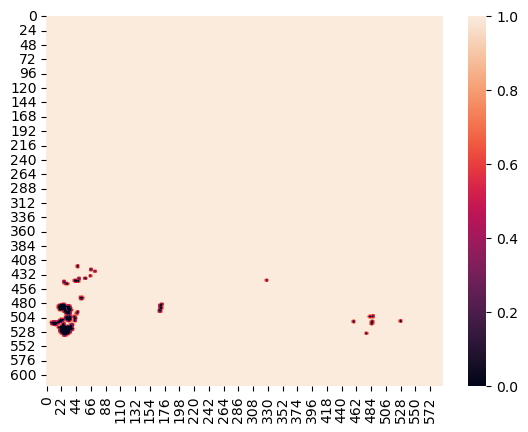

In [51]:
img = np.load("../src/bi.npy")

def identify_bright_bare_surfaces(img):

    def _evi(x: np.ndarray, verbose: bool = False) -> np.ndarray:
        BLUE = np.clip(x[..., 0], 0, 1)
        GREEN = np.clip(x[..., 1], 0, 1)
        RED = np.clip(x[..., 2], 0, 1)
        NIR = np.clip(x[..., 3], 0, 1)
        evis = 2.5 * ((NIR - RED) / (NIR + (6 * RED) - (7.5 * BLUE) + 1))
        evis = np.clip(evis, -1.5, 1.5)
        return evis
    nir_swir_ratio = (img[..., 3] / (img[..., 8] + 0.01))
    nir_swir_ratio = nir_swir_ratio < 0.9
    nir_swir_ratio = nir_swir_ratio * (np.mean(img[..., :3], axis = -1) > 0.2)
    nir_swir_ratio = nir_swir_ratio * (_evi(img) < 0.3)
    bright_surface = np.sum((nir_swir_ratio), axis = 0) > 1
    blurred = distance(1 - bright_surface)
    blurred[blurred > 4] = 4
    blurred = (blurred / 4)
    #blurred = 1 - blurred
    return blurred

sns.heatmap(identify_bright_bare_surfaces(img))

# 